# Document Clustring

## Datasets
1. 20 news Groups
2. Kaggle dataset
3. Quora data

In [29]:
import utils
import numpy as np
import json
import logging
import os
import random
import textwrap
from collections import Counter, defaultdict
import plotly.express as px
import faiss
import shutil

import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from huggingface_hub import InferenceClient
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from tqdm import tqdm
from umap import UMAP
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time
import scipy
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from collections import defaultdict
from time import time
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN, HDBSCAN, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

logging.basicConfig(level=logging.INFO)

/home/srikanth/pyt5/lib/python3.11/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [44]:
df = utils.load_20newsgroups()
display (df)
print (f"Classes: {np.unique(df['label'])}")

,document,label
0,From: gatenb@mrisun.med.yale.edu (Chris Gatenb...,4
1,From: chu@TorreyPinesCA.ncr.com (Patrick Chu 3...,1
2,From: drchambe@tekig5.pen.tek.com (Dennis Cham...,14
3,From: stafford@lobby.ti.com (Ron Stafford)\nSu...,7
4,From: keith@cco.caltech.edu (Keith Allan Schne...,0
...,...,...
18840,From: adam@endor.uucp (Adam Shostack)\nSubject...,17
18841,From: diederic@spot.Colorado.EDU (Andrew Diede...,16
18842,From: garrett@Ingres.COM (GREP A FRIEND)\nSubj...,18
18843,From: kdw@icd.ab.com (Kenneth D. Whitehead)\nS...,16


Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [22]:
df = utils.load_kaggle_data()
display (df)
print (f"Classes: {np.unique(df['label'])}")

,document,label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0
...,...,...
2219,Stock market eyes Japan recovery\n \n Japanese...,4
2220,India opens skies to competition\n \n India wi...,4
2221,Yukos bankruptcy 'not US matter'\n \n Russian ...,4
2222,Survey confirms property slowdown\n \n Governm...,4


Classes: [0 1 2 3 4]


In [25]:
df = utils.load_quora_qa_data()
display (df)

,document,answer
0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...
2,"What song has the lyrics ""someone left the cak...",MacArthur's Park\n
3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...
4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...
...,...,...
56396,Why are we allowed to say that a polynomial,Because there is an isomorphism from any [math...
56397,"Alexandria Ocasio-Cortez said ""Going by track ...","I think she’s right, one is a homosexual with ..."
56398,Is becoming a doctor financially worth it?,Yes if you want to help people and eliminate p...
56399,Where can one find the best biryani in bangalore?,Biryani crafts.These guys will give proper aut...


## Clustering Alogrithms
1. KMeans
2. MiniBatchKMeans
3. DBSCAN
4. Aggloerative clustering

### Evaluation Metrics
1. Homogenerity
2. Completeness
3. V-measure
4. Adjusted Rand Index
5. Silhouette Coefficient

# Look at the utils.py code

# Look at the design diagram

# Look at the code

# Deepdive into 20newgroups

In [45]:
shutil.rmtree("images", ignore_errors=True)
os.makedirs("images", exist_ok=True)

evaluations = []
evaluations_std = []

# Load Data
data = utils.load_20newsgroups(limit_to=10000)

# Data Stats
df = data.groupby(["label"]).apply("count").reset_index()

fig = px.bar(df, x="label", y="document", title="20 NewsGroups Dataset")
fig.write_image(f"images/data.png")

logging.info(data["document"].head())
logging.info(f"Shape: {data.shape}")
n_clusters = 20

INFO:root:0    From: gatenb@mrisun.med.yale.edu (Chris Gatenb...
1    From: chu@TorreyPinesCA.ncr.com (Patrick Chu 3...
2    From: drchambe@tekig5.pen.tek.com (Dennis Cham...
3    From: stafford@lobby.ti.com (Ron Stafford)\nSu...
4    From: keith@cco.caltech.edu (Keith Allan Schne...
Name: document, dtype: object
INFO:root:Shape: (10000, 2)


In [46]:
from clustering import Clusters
# 1. With out cleaning and Without Dim reductions

clusters = Clusters(
    embeddings={
        "model": "tfidf",
        "config": {
            "max_df": 0.5,  # ignoring terms that appear in more than 50% of the documents
            "min_df": 5,  # ignoring terms that appear in less than 5 documents
            "stop_words": "english",
        },
    },
    dim_reduction=None,
    clustering=None,
)

clusters.fit(data["document"].to_list())

INFO:root:Vectorizing using tfidf
INFO:root:vectorization done in 1.771 s
INFO:root:Size: 10000, n_features: 23446
INFO:root:Sparcity: 0.004


In [47]:
 # 2. Dim reduction using SVD
clusters = Clusters(
    embeddings={
        "model": "tfidf",
        "config": {
            "max_df": 0.5,  # ignoring terms that appear in more than 50% of the documents
            "min_df": 5,  # ignoring terms that appear in less than 5 documents
            "stop_words": "english",
        },
    },
    dim_reduction={
        "model": "svd",
        "config": {"n_components": 100},
    },
    clustering=None,
)

clusters.fit(data["document"].to_list())

INFO:root:Vectorizing using tfidf
INFO:root:vectorization done in 1.759 s
INFO:root:Size: 10000, n_features: 23446
INFO:root:Sparcity: 0.004
INFO:root:Dimensionality Reduction using svd
INFO:root:SVD done in 1.509 s
INFO:root:Explained variance of the SVD step: 12.8%


In [48]:
# 3. Kmeans depends on the cluster centroids initialize
for i in range(5):
    _, cluster_ids, cluster_sizes = clusters.cluster(
        clusters.X,
        clustering={
            "model": "KMeans",
            "config": {
                "n_clusters": n_clusters,
                "max_iter": 100,
                "n_init": 1,
                "random_state": i,
            },
        },
    )
    logging.info(f"Cluster Sizes: {cluster_sizes}")

_, category_sizes = np.unique(data["label"], return_counts=True)
logging.info(f"True Cluster Sizes: {category_sizes}")

INFO:root:Clustering using KMeans
INFO:root:Cluster Sizes: [  78  339 1702 1053  329  338  432  316  551  593  720  383  333  376
  135  154  363  882  677  246]
INFO:root:Clustering using KMeans
INFO:root:Cluster Sizes: [ 344  858  592  317  973  261  247 2013  115  274  818  338  417  417
  674  148  131  175  369  519]
INFO:root:Clustering using KMeans
INFO:root:Cluster Sizes: [ 689  286  383  851  751  344 1840  330  375  301  360  577  237  253
  613  380  963  188  152  127]
INFO:root:Clustering using KMeans
INFO:root:Cluster Sizes: [ 125  237  495  604  391  342  723  245 1994  319  299  694  151  379
  187  426  593  148  915  733]
INFO:root:Clustering using KMeans
INFO:root:Cluster Sizes: [ 144  675  160  629  286  361  708  352  630  639  331 1175 2061  154
  189  132  187  415  434  338]
INFO:root:True Cluster Sizes: [426 522 541 518 497 525 527 535 525 528 546 512 515 541 510 526 471 492
 398 345]


In [49]:
# 4. fit and eval
clusters = Clusters(
    embeddings={
        "model": "tfidf",
        "config": {
            "max_df": 0.5,  # ignoring terms that appear in more than 50% of the documents
            "min_df": 5,  # ignoring terms that appear in less than 5 documents
            "stop_words": "english",
        },
    },
    dim_reduction=None,
    clustering={
        "model": "KMeans",
        "config": {
            "n_clusters": n_clusters,
            "max_iter": 100,
            "n_init": 1,
        },
        "evaluate": True,
    },
)

clusters.fit(
    data["document"].to_list(),
    data["label"].to_list(),
    evaluations,
    evaluations_std,
)

INFO:root:Vectorizing using tfidf
INFO:root:vectorization done in 1.788 s
INFO:root:Size: 10000, n_features: 23446
INFO:root:Sparcity: 0.004
INFO:root:Clustering using KMeans
INFO:root:clustering done in 1.93 ± 0.28 s 
INFO:root:Homogeneity: 0.343 ± 0.022
INFO:root:Completeness: 0.413 ± 0.038
INFO:root:V-measure: 0.374 ± 0.029
INFO:root:Adjusted Rand-Index: 0.143 ± 0.018
INFO:root:Silhouette Coefficient: 0.007 ± 0.000


In [50]:
# 5. Putting it all together with kmeans
clusters = Clusters(
    embeddings={
        "model": "tfidf",
        "config": {
            "max_df": 0.5,  # ignoring terms that appear in more than 50% of the documents
            "min_df": 5,  # ignoring terms that appear in less than 5 documents
            "stop_words": "english",
        },
    },
    dim_reduction={
        "model": "svd",
        "config": {"n_components": 100},
    },
    clustering={
        "model": "KMeans",
        "config": {
            "n_clusters": n_clusters,
            "max_iter": 100,
            "n_init": 1,
        },
        "evaluate": True,
    },
)

clusters.fit(
    data["document"].to_list(),
    data["label"].to_list(),
    evaluations,
    evaluations_std,
)

INFO:root:Vectorizing using tfidf
INFO:root:vectorization done in 1.790 s
INFO:root:Size: 10000, n_features: 23446
INFO:root:Sparcity: 0.004
INFO:root:Dimensionality Reduction using svd
INFO:root:SVD done in 1.489 s
INFO:root:Explained variance of the SVD step: 12.8%
INFO:root:Clustering using KMeans
INFO:root:clustering done in 0.12 ± 0.01 s 
INFO:root:Homogeneity: 0.372 ± 0.013
INFO:root:Completeness: 0.404 ± 0.016
INFO:root:V-measure: 0.388 ± 0.014
INFO:root:Adjusted Rand-Index: 0.186 ± 0.009
INFO:root:Silhouette Coefficient: 0.066 ± 0.000


INFO:root:Vectorizing using tfidf
INFO:root:vectorization done in 1.756 s
INFO:root:Size: 10000, n_features: 23446
INFO:root:Sparcity: 0.004
INFO:root:Clustering using KMeans
INFO:root:clustering done in 2.10 ± 0.32 s 
INFO:root:Homogeneity: 0.343 ± 0.022
INFO:root:Completeness: 0.413 ± 0.038
INFO:root:V-measure: 0.374 ± 0.029
INFO:root:Adjusted Rand-Index: 0.143 ± 0.018
INFO:root:Silhouette Coefficient: 0.008 ± 0.000
INFO:root:Vectorizing using tfidf
INFO:root:vectorization done in 1.760 s
INFO:root:Size: 10000, n_features: 23446
INFO:root:Sparcity: 0.004
INFO:root:Dimensionality Reduction using svd
INFO:root:SVD done in 1.568 s
INFO:root:Explained variance of the SVD step: 12.8%
INFO:root:Clustering using KMeans
INFO:root:clustering done in 0.09 ± 0.02 s 
INFO:root:Homogeneity: 0.394 ± 0.005
INFO:root:Completeness: 0.429 ± 0.006
INFO:root:V-measure: 0.411 ± 0.005
INFO:root:Adjusted Rand-Index: 0.208 ± 0.018
INFO:root:Silhouette Coefficient: 0.069 ± 0.000
INFO:root:Vectorizing using t

'images_20newsgroups'

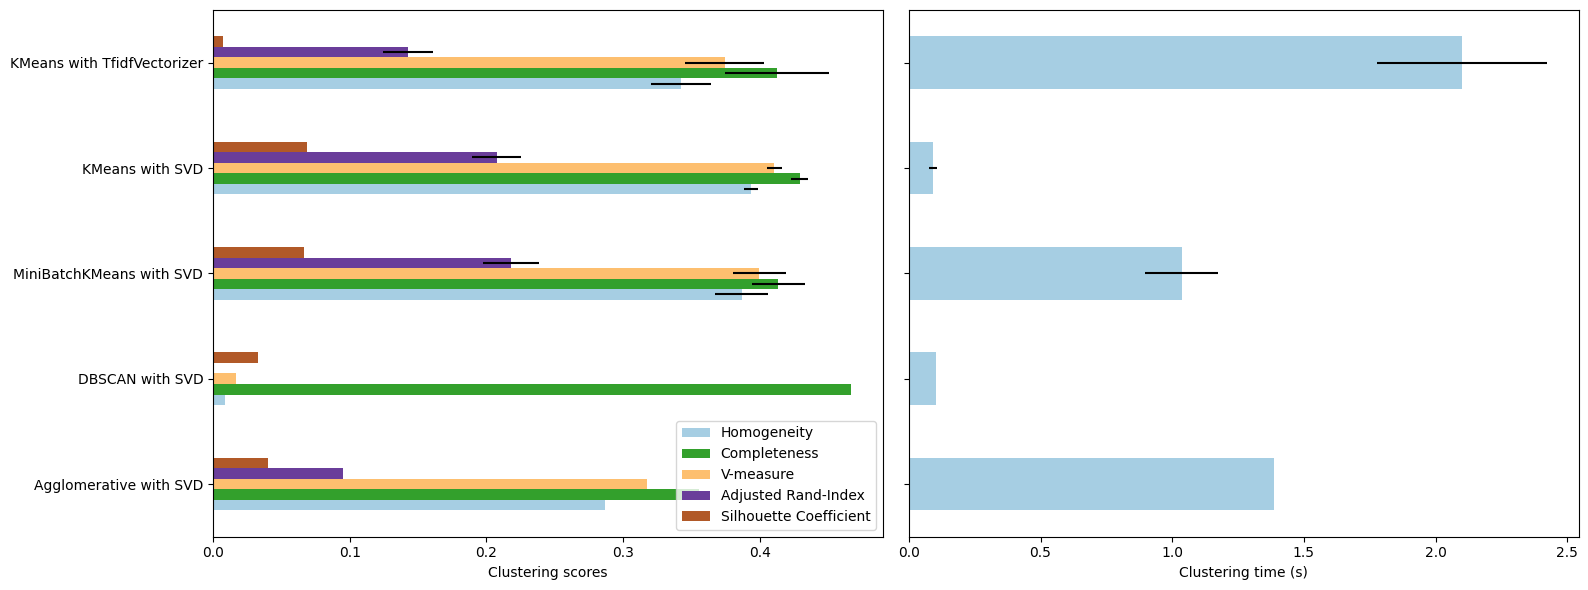

In [51]:
# 6. Putting it all together
evaluations = []
evaluations_std = []

Clusters(
    exp_name="KMeans with TfidfVectorizer",
    embeddings={
        "model": "tfidf",
        "config": {
            "max_df": 0.5,  # ignoring terms that appear in more than 50% of the documents
            "min_df": 5,  # ignoring terms that appear in less than 5 documents
            "stop_words": "english",
        },
    },
    dim_reduction=None,
    clustering={
        "model": "KMeans",
        "config": {
            "n_clusters": n_clusters,
            "max_iter": 100,
            "n_init": 1,
        },
        "evaluate": True,
    },
).fit(
    data["document"].to_list(),
    data["label"].to_list(),
    evaluations,
    evaluations_std,
)

Clusters(
    exp_name="KMeans with SVD",
    embeddings={
        "model": "tfidf",
        "config": {
            "max_df": 0.5,  # ignoring terms that appear in more than 50% of the documents
            "min_df": 5,  # ignoring terms that appear in less than 5 documents
            "stop_words": "english",
        },
    },
    dim_reduction={
        "model": "svd",
        "config": {"n_components": 100},
    },
    clustering={
        "model": "KMeans",
        "config": {
            "n_clusters": n_clusters,
            "max_iter": 100,
            "n_init": 1,
        },
        "evaluate": True,
    },
).fit(
    data["document"].to_list(),
    data["label"].to_list(),
    evaluations,
    evaluations_std,
)

Clusters(
    exp_name="MiniBatchKMeans with SVD",
    embeddings={
        "model": "tfidf",
        "config": {
            "max_df": 0.5,  # ignoring terms that appear in more than 50% of the documents
            "min_df": 5,  # ignoring terms that appear in less than 5 documents
            "stop_words": "english",
        },
    },
    dim_reduction={
        "model": "svd",
        "config": {"n_components": 100},
    },
    clustering={
        "model": "MiniBatchKMeans",
        "config": {
            "n_clusters": n_clusters,
            "init_size": 1000,
            "batch_size": 1000,
            "n_init": 1,
        },
        "evaluate": True,
    },
).fit(
    data["document"].to_list(),
    data["label"].to_list(),
    evaluations,
    evaluations_std,
)

Clusters(
    exp_name="DBSCAN with SVD",
    embeddings={
        "model": "tfidf",
        "config": {
            "max_df": 0.5,  # ignoring terms that appear in more than 50% of the documents
            "min_df": 5,  # ignoring terms that appear in less than 5 documents
            "stop_words": "english",
        },
    },
    dim_reduction={
        "model": "svd",
        "config": {"n_components": 100},
    },
    clustering={
        "model": "dbscan",  # "hdbscan",
        "config": {
            "eps": 0.3,
            "min_samples": 25,
        },
        "evaluate": True,
    },
).fit(
    data["document"].to_list(),
    data["label"].to_list(),
    evaluations,
    evaluations_std,
)


Clusters(
    exp_name="Agglomerative with SVD",
    embeddings={
        "model": "tfidf",
        "config": {
            "max_df": 0.5,  # ignoring terms that appear in more than 50% of the documents
            "min_df": 5,  # ignoring terms that appear in less than 5 documents
            "stop_words": "english",
        },
    },
    dim_reduction={
        "model": "svd",
        "config": {"n_components": 100},
    },
    clustering={
        "model": "agglomerative",
        "config": {
            "linkage": "ward",
            "metric": "euclidean",
            "n_clusters": n_clusters,
        },
        "evaluate": True,
    },
).fit(
    data["document"].to_list(),
    data["label"].to_list(),
    evaluations,
    evaluations_std,
)

# Plots

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std, colormap="Paired")
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"], colormap="Paired")
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()

plt.savefig("images/comparision.png")

shutil.copytree("images", "images_20newsgroups", dirs_exist_ok=True)


In [41]:
from clustering import demo_kaggle, demo_quora

INFO:root:0    Budget to set scene for election\n \n Gordon B...
1    Army chiefs in regiments decision\n \n Militar...
2    Howard denies split over ID cards\n \n Michael...
3    Observers to monitor UK election\n \n Minister...
4    Kilroy names election seat target\n \n Ex-chat...
Name: document, dtype: object
INFO:root:Shape: (2224, 2)
INFO:root:Vectorizing using tfidf
INFO:root:vectorization done in 0.505 s
INFO:root:Size: 2224, n_features: 9135
INFO:root:Sparcity: 0.014
INFO:root:Clustering using KMeans
INFO:root:Cluster Sizes: [ 378 1008  357  285  196]
INFO:root:Clustering using KMeans
INFO:root:Cluster Sizes: [ 340  264 1079  168  373]
INFO:root:Clustering using KMeans
INFO:root:Cluster Sizes: [902 359 503 306 154]
INFO:root:Clustering using KMeans
INFO:root:Cluster Sizes: [511 344 238 749 382]
INFO:root:Clustering using KMeans
INFO:root:Cluster Sizes: [380 395 955 329 165]
INFO:root:True Cluster Sizes: [417 511 401 386 509]
INFO:root:Vectorizing using tfidf
INFO:root:vectoriz

([{'estimator': 'KMeans with TfidfVectorizer',
   'train_time': 0.0546534538269043,
   'Homogeneity': 0.6278907981001143,
   'Completeness': 0.6915706437126176,
   'V-measure': 0.6580143314257769,
   'Adjusted Rand-Index': 0.5433164699087829,
   'Silhouette Coefficient': 0.01257564494011672},
  {'estimator': 'KMeans with SVD',
   'train_time': 0.053154706954956055,
   'Homogeneity': 0.7913953652120221,
   'Completeness': 0.8141695847151735,
   'V-measure': 0.8021443855634496,
   'Adjusted Rand-Index': 0.783924910191125,
   'Silhouette Coefficient': 0.06794906020025289},
  {'estimator': 'MiniBatchKMeans with SVD',
   'train_time': 0.5458803653717041,
   'Homogeneity': 0.7321710426974732,
   'Completeness': 0.7564331082509216,
   'V-measure': 0.7439149122304085,
   'Adjusted Rand-Index': 0.7118772518865202,
   'Silhouette Coefficient': 0.07021433296231697},
  {'estimator': 'DBSCAN with SVD',
   'train_time': 0.03271651268005371,
   'Homogeneity': 0.052028819600563526,
   'Completeness': 

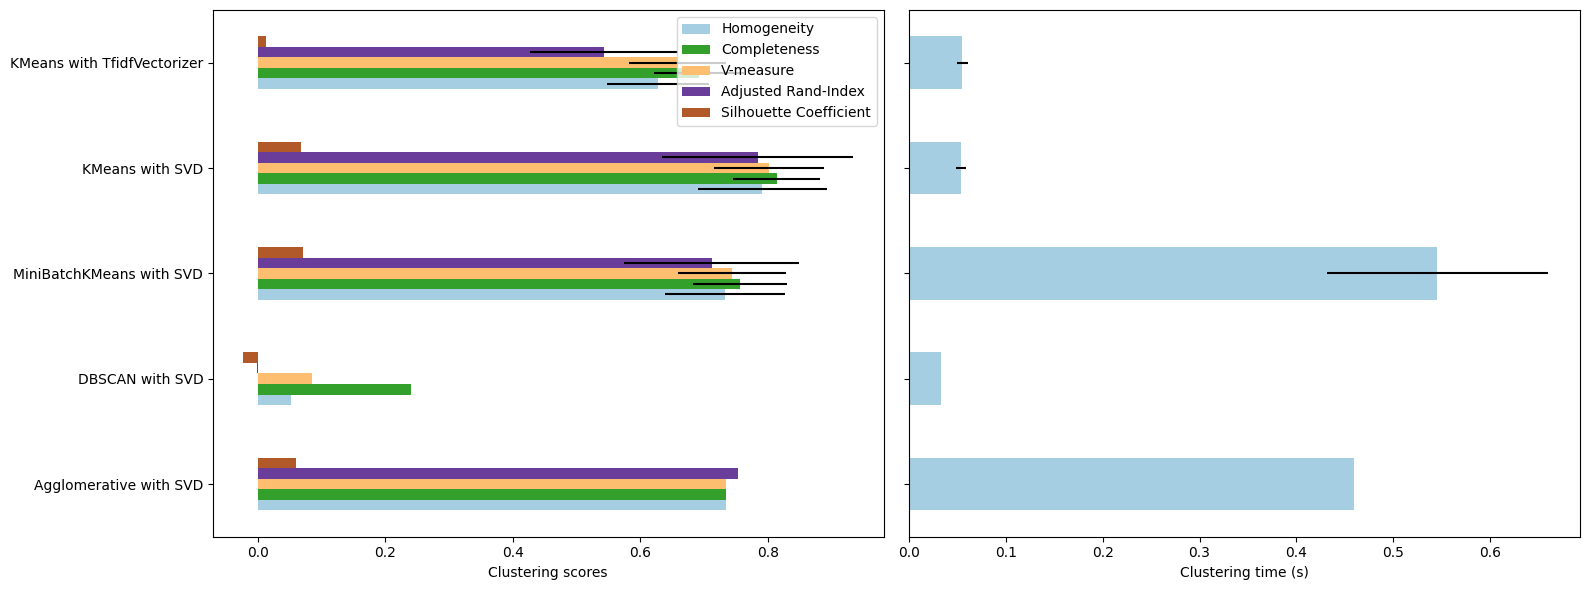

In [42]:
demo_kaggle()

INFO:root:0    Why whenever I get in the shower my girlfriend...
1              What is a proxy, and how can I use one?
2    What song has the lyrics "someone left the cak...
3    I am the owner of an adult website called http...
4    Does the Bible mention anything about a place ...
Name: document, dtype: object
INFO:root:Shape: (10000, 2)
INFO:root:Vectorizing using tfidf
INFO:root:vectorization done in 0.114 s
INFO:root:Size: 10000, n_features: 2898
INFO:root:Sparcity: 0.002
INFO:root:Dimensionality Reduction using svd
INFO:root:SVD done in 0.354 s
INFO:root:Explained variance of the SVD step: 28.9%
INFO:root:Vectorizing using tfidf
INFO:root:vectorization done in 0.109 s
INFO:root:Size: 10000, n_features: 2898
INFO:root:Sparcity: 0.002
INFO:root:Clustering using KMeans
INFO:root:Cluster Sizes: [   9 7126   22   24   20   23   21   14   20   28   23   24   17   13
   25   19   25   25   16   20   16   13   20   19   23   20   18   11
   26   21   17   27   23   24   21   13   16   2

([{'estimator': 'KMeans with TfidfVectorizer',
   'train_time': 0.43772873878479,
   'Silhouette Coefficient': 0.21673465890677898},
  {'estimator': 'KMeans with SVD',
   'train_time': 0.18499245643615722,
   'Silhouette Coefficient': 0.34937820743813913},
  {'estimator': 'MiniBatchKMeans with SVD',
   'train_time': 0.8682131290435791,
   'Silhouette Coefficient': 0.35722575525952893},
  {'estimator': 'DBSCAN with SVD',
   'train_time': 0.22559595108032227,
   'Silhouette Coefficient': 0.5621903861394266},
  {'estimator': 'Agglomerative with SVD',
   'train_time': 150.22111058235168,
   'Silhouette Coefficient': 0.37692804251327067}],
 [{'estimator': 'KMeans with TfidfVectorizer',
   'train_time': 0.06811322509628959,
   'Silhouette Coefficient': 0.0},
  {'estimator': 'KMeans with SVD',
   'train_time': 0.004925662733609654,
   'Silhouette Coefficient': 0.0},
  {'estimator': 'MiniBatchKMeans with SVD',
   'train_time': 0.09790147297951522,
   'Silhouette Coefficient': 0.0},
  {'estimat

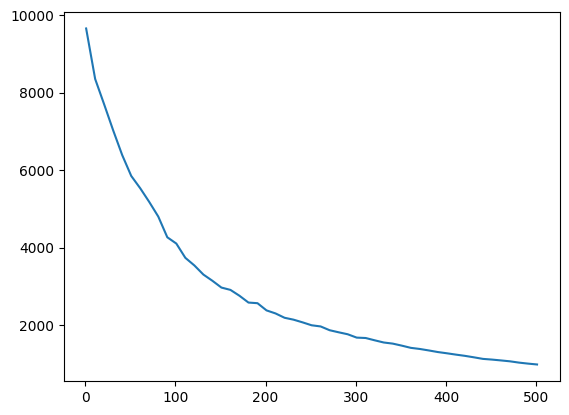

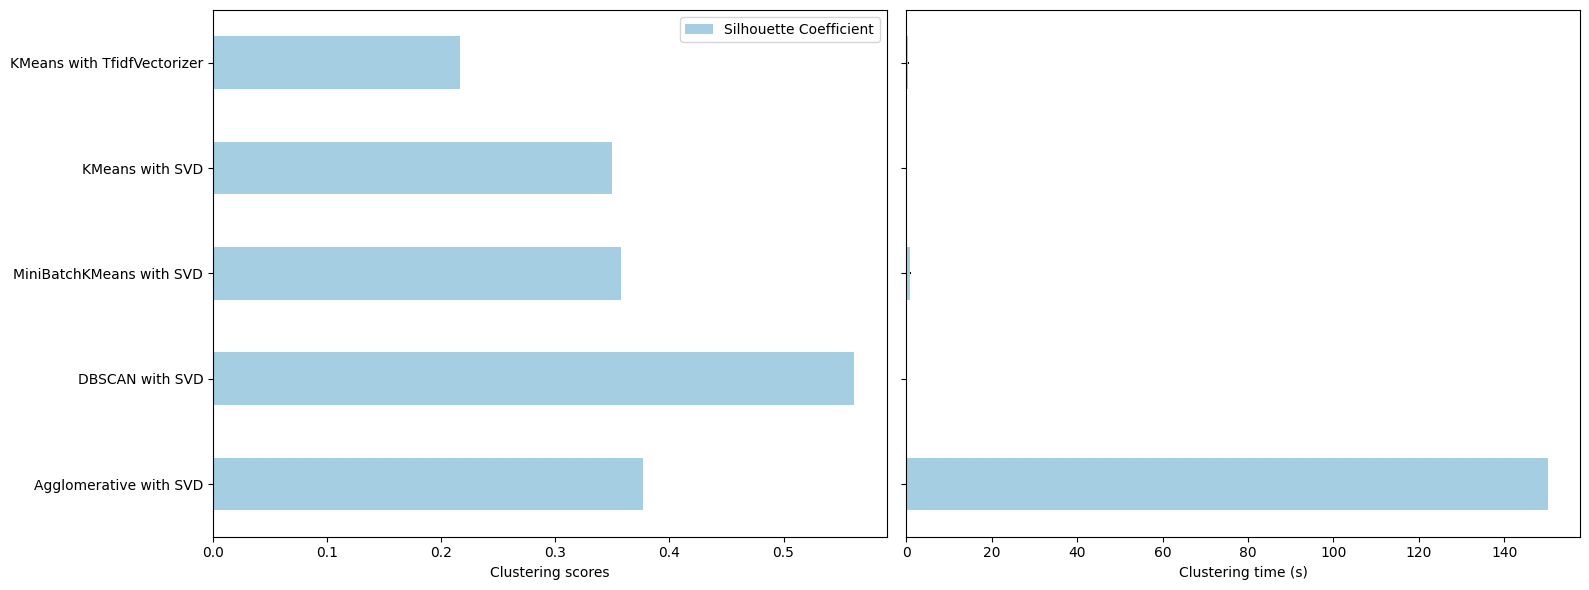

In [43]:
demo_quora()